Rugby FL DS

In [73]:
import pandas as pd


In [74]:
results_df = pd.read_csv('results.csv')

def restructure_dataframe(df):
    # Create Season column
    results_df['Game_Date'] = pd.to_datetime(results_df['Game_Date'])
    results_df['Season'] = results_df['Game_Date'].dt.year + 1 * (results_df['Game_Date'].dt.month >= 9)
    
    new_cols = [
        'Game_ID', 'Championship_ID', 'Team_ID', 'Team_Name', 'Team_Score', 
        'Opponent_ID', 'Opponent_Name', 'Opponent_Score', 'Game_Date', 'Season', 'Is_Home'
    ]
    home_df = df.rename(columns={
        'Home_Club_ID': 'Team_ID',
        'Home_Club_AKA': 'Team_Name',
        'Home_Score': 'Team_Score',
        'Away_Club_ID': 'Opponent_ID',
        'Away_Club_AKA': 'Opponent_Name',
        'Away_Score': 'Opponent_Score'
    })
    home_df['Is_Home'] = True

    away_df = df.rename(columns={
        'Away_Club_ID': 'Team_ID',
        'Away_Club_AKA': 'Team_Name',
        'Away_Score': 'Team_Score',
        'Home_Club_ID': 'Opponent_ID',
        'Home_Club_AKA': 'Opponent_Name',
        'Home_Score': 'Opponent_Score'
    })
    away_df['Is_Home'] = False
    
    restructured_df = pd.concat([home_df, away_df], ignore_index=False)

    # Reorder the columns
    restructured_df = restructured_df[new_cols]
    # Sort the rows by Game_ID
    restructured_df = restructured_df.sort_values(by='Game_ID')

    return restructured_df

# Drop any 0-0 games
results_df = results_df[(results_df['Home_Score'] != 0) & (results_df['Away_Score'] != 0)]

results_df = restructure_dataframe(results_df)

In [75]:
# functions to calculate each part of the elo formula

from pandas import DataFrame


class Elo:
    def __init__(self, df: DataFrame, k_factor=20, home_advantage=100, starting_elo=1505):
        self.df = df  # dataframe with all the games
        self.elo_dict = {}  # dictionary with team names as keys and elo ratings as values
        self.k_factor = k_factor
        self.home_advantage = home_advantage
        self.starting_elo = starting_elo
        self.init_elo_dict()


    def find_elo_ratings_season(self, season: int):
        season_df = self.df[self.df['Season'] == season]
        games = season_df['Game_ID'].unique()

        for game_id in games:
            home_row = season_df[(season_df['Game_ID'] == game_id) & (
                season_df['Is_Home'] == True)]
            away_row = season_df[(season_df['Game_ID'] == game_id) & (
                season_df['Is_Home'] == False)]

            home_team = home_row.iloc[0]['Team_Name']
            away_team = away_row.iloc[0]['Team_Name']
            
            home_elo = self.elo_dict.get(home_team)
            away_elo = self.elo_dict.get(away_team)
            
            print(f"Game ID: {game_id}, Home Team: {home_team}, Away Team: {away_team}")
            print(f"Initial Elo: Home: {home_elo}, Away: {away_elo}")

            # Update DataFrame with current Elo ratings
            self.df.loc[home_row.index, 'Team_Elo'] = home_elo
            self.df.loc[away_row.index, 'Team_Elo'] = away_elo
            self.df.loc[away_row.index, 'Opponent_Elo'] = home_elo
            self.df.loc[home_row.index, 'Opponent_Elo'] = away_elo

            margin_of_victory = home_row.iloc[0]['Team_Score'] - \
                away_row.iloc[0]['Team_Score']

            home_elo_change, away_elo_change = self.find_elo_change(
                home_team, away_team, margin_of_victory)

            print(f"Elo Changes: Home: {home_elo_change}, Away: {away_elo_change}")

            # Update elo_dict with new elo ratings
            self.elo_dict[home_team] = home_elo + home_elo_change
            self.elo_dict[away_team] = away_elo + away_elo_change
            
            # Update DataFrame with Elo changes
            self.df.loc[home_row.index, 'Elo_Change'] = home_elo_change
            self.df.loc[away_row.index, 'Elo_Change'] = away_elo_change

            print(f"Updated Elo: Home: {self.elo_dict[home_team]}, Away: {self.elo_dict[away_team]}")



    def init_elo_dict(self):
        teams = self.df['Team_Name'].unique()
        for team in teams:
            self.elo_dict[team] = self.starting_elo

    def find_elo_ratings_season_decay(self, season: DataFrame, elo_dict: dict):
        for team in elo_dict:
            elo_dict[team] = self.find_decay_elo(elo_dict[team])
        return elo_dict

    def find_elo_change(self, home_team: str, away_team: str, margin_of_victory: int):
        elo_home = self.elo_dict[home_team]
        elo_away = self.elo_dict[away_team]

        elo_diff = elo_home - elo_away

        K_home, K_away = self.find_K(margin_of_victory, elo_diff)
        S_home, S_away = self.find_S(margin_of_victory)
        E_home, E_away = self.find_E(elo_home, elo_away)

        elo_home = K_home * (S_home - E_home)
        elo_away = K_away * (S_away - E_away)

        return int(elo_home), int(elo_away)

    def find_K(self, margin_of_victory: int, elo_diff: int) -> int:
        # K is multiplier to apply to the elo change
        # the multiplier function is from 538, as is the k_0 value
        # positive MOV means home team won
        k_factor = self.k_factor
        if margin_of_victory > 0:  # home team won
            multiplier = (margin_of_victory + 3) ** 0.8 / \
                (7.5 + 0.006 * elo_diff)
        else:  # home team lost
            multiplier = (-margin_of_victory + 3) ** 0.8 / \
                (7.5 + 0.006 * -elo_diff)
        # returns two values, one for each team
        return k_factor * multiplier, k_factor * multiplier

    def find_S(self, margin_of_victory: int):
        if margin_of_victory > 0:  # home team won
            return 1, 0
        elif margin_of_victory < 0:  # home team lost
            return 0, 1
        else:
            return 0.5, 0.5  # tie

    def find_E(self, elo_home: int, elo_away: int) -> tuple[float, float]:
        home_adv = self.home_advantage
        elo_home += home_adv

        E_home = 1 / (1 + 10 ** ((elo_away - elo_home) / 400.0))
        E_away = 1 / (1 + 10 ** ((elo_home - elo_away) / 400.0))

        return E_home, E_away

    def find_decay_elo(self, elo: int) -> int:
        """
        Decay the elo rating by 25% to the mean, set at 1505 to account for
        new teams joining. 
        """
        return int(elo * 0.75 + 1505 * 0.25)

In [76]:
results_df.loc[results_df['Season'] == 2024]

,Game_ID,Championship_ID,Team_ID,Team_Name,Team_Score,Opponent_ID,Opponent_Name,Opponent_Score,Game_Date,Season,Is_Home
3576,10157,158,121,St. Thomas,43,34,UCF M,7,2023-10-21,2024,False
3576,10157,158,34,UCF M,7,121,St. Thomas,43,2023-10-21,2024,True
3577,10158,158,117,Claymores RFC,19,34,UCF M,43,2023-11-05,2024,False
3577,10158,158,34,UCF M,43,117,Claymores RFC,19,2023-11-05,2024,True
3578,10160,158,34,UCF M,53,32,FAU Rugby Men,17,2023-12-02,2024,True
...,...,...,...,...,...,...,...,...,...,...,...
3890,11630,161,7,Tampa Krewe,59,44,Out of State,14,2024-05-19,2024,True
3891,11631,157,44,Out of State,21,6,Miami Tridents,34,2024-05-18,2024,False
3891,11631,157,6,Miami Tridents,34,44,Out of State,21,2024-05-18,2024,True
3892,11632,157,6,Miami Tridents,38,44,Out of State,10,2024-05-19,2024,True


In [77]:
elo = Elo(results_df)

start_season = results_df['Season'].min()
current_season = start_season

# elo.find_elo_ratings_season(2024)

seasons = results_df['Season'].unique()
for season in seasons:
    # Not decaying ratings
    # if season != start_season:
    #     for team in elo_dict:
    #         elo_dict[team] = find_decay_elo(elo_dict[team])
    print(elo.find_elo_ratings_season(season))

Game ID: 49, Home Team: Ft. Lauderdale, Away Team: Miami Tridents
Initial Elo: Home: 1505, Away: 1505
Elo Changes: Home: 10, Away: -10


KeyError: 'Elo_Change'

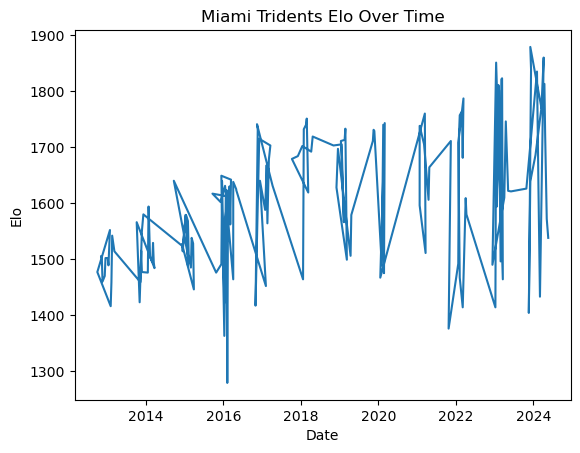

In [ ]:
import matplotlib.pyplot as plt
# Miami Tridents Elo over time
tridents_df = results_df[results_df['Team_Name'] == 'Miami Tridents'][['Game_Date', 'Team_Elo']]
plt.plot(tridents_df['Game_Date'], tridents_df['Team_Elo'])
plt.title('Miami Tridents Elo Over Time')
plt.xlabel('Date')
plt.ylabel('Elo')
plt.show()

In [ ]:
tridents_df = results_df[results_df['Team_Name'] == 'Miami Tridents']
print(tridents_df)

      Game_ID  Championship_ID  Team_ID       Team_Name  Team_Score  \
0          49                9        6  Miami Tridents           3   
2          51                9        6  Miami Tridents          12   
5          54                9        6  Miami Tridents          23   
9          58                9        6  Miami Tridents          22   
10         59                9        6  Miami Tridents          29   
...       ...              ...      ...             ...         ...   
3870    11609              157        6  Miami Tridents          67   
3881    11620              157        6  Miami Tridents          36   
3886    11625              157        6  Miami Tridents          29   
3891    11631              157        6  Miami Tridents          34   
3892    11632              157        6  Miami Tridents          38   

      Opponent_ID   Opponent_Name  Opponent_Score  Game_Date  Season  Is_Home  \
0               5  Ft. Lauderdale              21 2012-11-03    20